# `Pre-processing`

## 1 Setup

### 1.1 Libraries

In [193]:
import pandas as pd
import numpy as np

### 1.2 Paths

In [194]:
# DEPRESSION_PATH             = '/workspaces/depressao-ibge-pns/data/depression.csv'
# DEPRESSION_DICTIONARY_PATH  = '/workspaces/depressao-ibge-pns/data/depression-dictionary.csv'
DEPRESSION_PATH             = 'depression.csv'
DEPRESSION_DICTIONARY_PATH  = 'depression-dictionary.csv'

### 1.3 Dataframes

In [195]:
DEPRESSION            = pd.read_csv(DEPRESSION_PATH, header=[0, 1])
DEPRESSION_DICTIONARY = pd.read_csv(DEPRESSION_DICTIONARY_PATH)

In [196]:
DEPRESSION.head()

,V0001,V0026,V0031,C006,C00703,C008,C009,C01001,C013,C017,...,V033,V034,V03501,V03502,V03503,V036,V037,V038,V039,Y008
,Unidade da Federação,Tipo de situação censitária,Tipo de área,Sexo,Ano de nascimento,Idade do morador na data de referência,Cor ou raça,Cônjuge ou companheiro(a) mora em nesse domicílio.,Cônjuge ou companheiro(a) mora em outro domicílio.,___já viveu com cônjuge ou companheiro (a) antes?,...,Onde isso ocorreu?,"Nos últimos doze meses, você deixou de realizar quaisquer de suas atividades habituais (trabalhar, realizar afazeres domésticos, ir à escola etc.) por causa desse ato","Esse(s) ato(s) sexual(is) forçado(s) gerou(aram) alguma consequência para sua saúde, tais como: Hematomas, cortes, fraturas, queimaduras ou outras lesões físicas ou ferimentos?","Esse(s) ato(s) sexual(is) forçado(s) gerou(aram) alguma consequência para sua saúde, tais como: Medo, tristeza, desânimo, dificuldade para dormir, ansiedade, depressão ou outras consequências psicológicas?","Esse(s) ato(s) sexual(is) forçado(s) gerou(aram) alguma consequência para sua saúde, tais como: Doença sexualmente transmissível ou gravidez indesejada?","Por causa desta (s) consequência (s), você procurou algum atendimento de saúde","Por causa desta (s) consequência (s), você recebeu algum atendimento de saúde",Onde foi realizado este atendimento de saúde,"Por causa desta (s) consequência (s), você precisou ser internado por 24 horas ou mais",Qual é a sua orientação sexual?
0,11,1,1,2.0,1963.0,55.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,11,1,1,1.0,1950.0,69.0,4.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11,1,1,1.0,1987.0,31.0,2.0,2.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,1,1,1.0,9999.0,9.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,1,1,2.0,9999.0,6.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
DEPRESSION_DICTIONARY.head()

,ModuloParteAnotacao,Posicao,Tamanho,Codigo,Numero,Descricao,Dtype,Tipo,Classe,Include,Felipe,Diego
0,Parte 1 - Identificação e Controle,1.0,2.0,V0001,NaN,Unidade da Federação,category,11,Rondônia,True,True,True
1,Parte 1 - Identificação e Controle,NaN,NaN,V0001,NaN,Unidade da Federação,NaN,12,Acre,True,True,True
2,Parte 1 - Identificação e Controle,NaN,NaN,V0001,NaN,Unidade da Federação,NaN,13,Amazonas,True,True,True
3,Parte 1 - Identificação e Controle,NaN,NaN,V0001,NaN,Unidade da Federação,NaN,14,Roraima,True,True,True
4,Parte 1 - Identificação e Controle,NaN,NaN,V0001,NaN,Unidade da Federação,NaN,15,Pará,True,True,True


## 1.4 Infer Attribute V03501 Descriptions
Attribute V03501 does not have value descriptions. We'll infer them as bool ('Sim' and 'Não', respectively), due to the description and pattern of the other attributes.


In [198]:
display(DEPRESSION_DICTIONARY[DEPRESSION_DICTIONARY['Codigo'] == 'V03501'])

DEPRESSION_DICTIONARY.loc[(DEPRESSION_DICTIONARY['Codigo'] == 'V03501') & (DEPRESSION_DICTIONARY['Tipo'] == '1'), 'Classe'] = 'Sim'
DEPRESSION_DICTIONARY.loc[(DEPRESSION_DICTIONARY['Codigo'] == 'V03501') & (DEPRESSION_DICTIONARY['Tipo'] == '2'), 'Classe'] = 'Não'

DEPRESSION_DICTIONARY[DEPRESSION_DICTIONARY['Codigo'] == 'V03501']

,ModuloParteAnotacao,Posicao,Tamanho,Codigo,Numero,Descricao,Dtype,Tipo,Classe,Include,Felipe,Diego
409,Módulo V - Violência (Para pessoas de 18 ano...,1275.0,1.0,V03501,V35,Esse(s) ato(s) sexual(is) forçado(s) gerou(ara...,bool,1,NaN,True,True,NaN
410,Módulo V - Violência (Para pessoas de 18 ano...,NaN,NaN,V03501,V35,Esse(s) ato(s) sexual(is) forçado(s) gerou(ara...,NaN,2,NaN,True,True,NaN
411,Módulo V - Violência (Para pessoas de 18 ano...,NaN,NaN,V03501,V35,Esse(s) ato(s) sexual(is) forçado(s) gerou(ara...,NaN,NaN,Não aplicável,False,False,False


,ModuloParteAnotacao,Posicao,Tamanho,Codigo,Numero,Descricao,Dtype,Tipo,Classe,Include,Felipe,Diego
409,Módulo V - Violência (Para pessoas de 18 ano...,1275.0,1.0,V03501,V35,Esse(s) ato(s) sexual(is) forçado(s) gerou(ara...,bool,1,Sim,True,True,NaN
410,Módulo V - Violência (Para pessoas de 18 ano...,NaN,NaN,V03501,V35,Esse(s) ato(s) sexual(is) forçado(s) gerou(ara...,NaN,2,Não,True,True,NaN
411,Módulo V - Violência (Para pessoas de 18 ano...,NaN,NaN,V03501,V35,Esse(s) ato(s) sexual(is) forçado(s) gerou(ara...,NaN,NaN,Não aplicável,False,False,False


## 2 [Implicit `NaNs`](https://github.com/feed0/depressao-ibge-pns/issues/4)
> Useless classes such as '09 - Ignored' become NaNs

>Here we define the `depression_explicit`: pd.DataFrame(),<br>
>which will drop useless classes such as **'09 - I don't know'**

In [199]:
# Here, `9999.0` means "Not answered"
DEPRESSION.C00703.value_counts(ascending=False).head(3)

Ano de nascimento
9999.0               16342
2000.0                4434
2004.0                4225
Name: count, dtype: int64

In [200]:
# These are the Tipos we need to annull

tipos_to_remove = DEPRESSION_DICTIONARY[
    (DEPRESSION_DICTIONARY.Tipo.notna())
    & (DEPRESSION_DICTIONARY.Include == False)
]

display(
    tipos_to_remove.shape,
    tipos_to_remove.head(3)
)

(39, 12)

,ModuloParteAnotacao,Posicao,Tamanho,Codigo,Numero,Descricao,Dtype,Tipo,Classe,Include,Felipe,Diego
37,Módulo C - Características gerais dos moradores,NaN,NaN,C00703,C7,Ano de nascimento,NaN,9999,Não informado,False,False,False
46,Módulo C - Características gerais dos moradores,NaN,NaN,C009,C9,Cor ou raça,NaN,9,Ignorado,False,False,False
50,Módulo C - Características gerais dos moradores,NaN,NaN,C01001,C10a,Cônjuge ou companheiro(a) mora em nesse domicí...,NaN,9,Ignorado,False,False,False


In [201]:
# In depression['C00703']   replace 9999    with np.nan
# In depression['C009']     replace 9       with np.nan
# ...
# In depression['Q109']  replace 9       with np.nan

depression_explicit = DEPRESSION.copy()

for codigo in tipos_to_remove.Codigo:
    
    # print(f'    [CODIGO]: {codigo} ==================================================')
    # print(f'    [BEFORE]:\n{depression_explicit[codigo].value_counts(ascending=False).head(3)}\n')

    code_tipos = tipos_to_remove.Tipo[tipos_to_remove.Codigo == codigo].values.astype(int)
    # print(f'    [CODE TIPOS]: === {code_tipos} ===')

    depression_explicit[codigo] = depression_explicit[codigo].replace(code_tipos, np.nan)
    # print(f'    [AFTER]:\n{depression_explicit[codigo].value_counts(ascending=False).head(2)}\n')

In [202]:
# Check the removal of the '9999' values
depression_explicit.C00703.value_counts(ascending=False).head(3)

Ano de nascimento
2000.0               4434
2004.0               4225
2005.0               4180
Name: count, dtype: int64

## 3: [Class `mapping`](https://github.com/feed0/depressao-ibge-pns/issues/7)
depression_without_implicit C00703

### 3.1 Each Codigo has its Tipos to be cast to their corresponding Classes

In [203]:
class_mappings: pd.DataFrame = DEPRESSION_DICTIONARY.loc[DEPRESSION_DICTIONARY['Tipo'].notna(), ['Codigo', 'Tipo', 'Classe']]
class_mappings.head()

,Codigo,Tipo,Classe
0,V0001,11,Rondônia
1,V0001,12,Acre
2,V0001,13,Amazonas
3,V0001,14,Roraima
4,V0001,15,Pará


### 3.2 Remove comments from class_mappings.Tipo

In [204]:
# Tipos which contain comments
non_numeric_tipos: pd.DataFrame = class_mappings[class_mappings['Tipo'].str.contains(r'[a-zA-Z]')]
non_numeric_tipos

,Codigo,Tipo,Classe
36,C00703,ano atual - 130 a ano atual,Ano
39,C008,000 a 130,Idade (em anos)
63,C01801,000 a 130,Idade (em anos)
168,P00103,1 a 599,Quilogramas
170,P00104,1 a 599,Quilogramas
177,P02801,1 a 7,Dias
185,P035,1 a 7,Dias
206,P053,1 a 98,Anos


In [205]:
# Annull these comments in class_mappings
class_mappings['Tipo'] = class_mappings['Tipo'].replace(r'[a-zA-Z]', np.nan, regex=True)

# Check the annullation
class_mappings[class_mappings['Tipo'].isna()]

,Codigo,Tipo,Classe
36,C00703,NaN,Ano
39,C008,NaN,Idade (em anos)
63,C01801,NaN,Idade (em anos)
168,P00103,NaN,Quilogramas
170,P00104,NaN,Quilogramas
177,P02801,NaN,Dias
185,P035,NaN,Dias
206,P053,NaN,Anos


In [206]:
# Drop these new null from class_mappings
class_mappings = class_mappings.dropna(subset=['Tipo'])

# Check the drop
class_mappings[class_mappings['Tipo'].isna()]

,Codigo,Tipo,Classe


### 3 `Map` Tipos to Classes

In [207]:
# Cast to int
class_mappings['Tipo'] = class_mappings['Tipo'].astype(int)

# These are the Tipos we need to map to their corresponding Classes
display(
    "[Class Mappings]",class_mappings.Tipo.shape, class_mappings.head(3),
    "[Depression]", depression_explicit.shape, depression_explicit.head(3),
)

'[Class Mappings]'

(353,)

,Codigo,Tipo,Classe
0,V0001,11,Rondônia
1,V0001,12,Acre
2,V0001,13,Amazonas


'[Depression]'

(293726, 87)

,V0001,V0026,V0031,C006,C00703,C008,C009,C01001,C013,C017,...,V033,V034,V03501,V03502,V03503,V036,V037,V038,V039,Y008
,Unidade da Federação,Tipo de situação censitária,Tipo de área,Sexo,Ano de nascimento,Idade do morador na data de referência,Cor ou raça,Cônjuge ou companheiro(a) mora em nesse domicílio.,Cônjuge ou companheiro(a) mora em outro domicílio.,___já viveu com cônjuge ou companheiro (a) antes?,...,Onde isso ocorreu?,"Nos últimos doze meses, você deixou de realizar quaisquer de suas atividades habituais (trabalhar, realizar afazeres domésticos, ir à escola etc.) por causa desse ato","Esse(s) ato(s) sexual(is) forçado(s) gerou(aram) alguma consequência para sua saúde, tais como: Hematomas, cortes, fraturas, queimaduras ou outras lesões físicas ou ferimentos?","Esse(s) ato(s) sexual(is) forçado(s) gerou(aram) alguma consequência para sua saúde, tais como: Medo, tristeza, desânimo, dificuldade para dormir, ansiedade, depressão ou outras consequências psicológicas?","Esse(s) ato(s) sexual(is) forçado(s) gerou(aram) alguma consequência para sua saúde, tais como: Doença sexualmente transmissível ou gravidez indesejada?","Por causa desta (s) consequência (s), você procurou algum atendimento de saúde","Por causa desta (s) consequência (s), você recebeu algum atendimento de saúde",Onde foi realizado este atendimento de saúde,"Por causa desta (s) consequência (s), você precisou ser internado por 24 horas ou mais",Qual é a sua orientação sexual?
0,11,1,1,2.0,1963.0,55.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,11,1,1,1.0,1950.0,69.0,4.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11,1,1,1.0,1987.0,31.0,2.0,2.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
# Map the Tipos to their corresponding Classes

columns = depression_explicit.columns.get_level_values(0).to_list()
class_mappings.loc[class_mappings['Codigo'] == columns[0], ['Tipo', 'Classe']]

for codigo in columns:

    # print(f'    [COLUMN]: {codigo} ==================================================')
    # print(f'    [BEFORE]:\n{depression_explicit[codigo].value_counts(ascending=False).head(3)}\n')

    # Mappings for the current column
    mappings = class_mappings.loc[class_mappings['Codigo'] == codigo, ['Tipo', 'Classe']]
    # display(mappings)

    # Mappings for the current column
    depression_explicit[codigo] = depression_explicit[codigo].replace(
        mappings['Tipo'].values.astype(int),
        mappings['Classe'].values
    )

    # print(f'    [AFTER]:\n{depression_explicit[codigo].value_counts(ascending=False).head(3)}\n')

In [209]:
depression_explicit['V0001'].value_counts(ascending=False).head(30)

Unidade da Federação
São Paulo               18504
Maranhão                17912
Minas Gerais            15421
Ceará                   15281
Rio de Janeiro          14776
Pará                    14393
Amazonas                13074
Pernambuco              12381
Paraná                  11694
Bahia                   11061
Espírito Santo          10673
Santa Catarina          10607
Alagoas                 10474
Rio Grande do Sul       10369
Paraíba                 10094
Rio Grande do Norte      9964
Piauí                    9044
Mato Grosso do Sul       8766
Goiás                    8506
Roraima                  8476
Acre                     8270
Sergipe                  8140
Distrito Federal         7609
Mato Grosso              7607
Rondônia                 7391
Amapá                    6640
Tocantins                6599
Name: count, dtype: int64

In [210]:
depression_explicit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293726 entries, 0 to 293725
Data columns (total 87 columns):
 #   Column                                                                                                                                                                                                                   Non-Null Count   Dtype  
---  ------                                                                                                                                                                                                                   --------------   -----  
 0   (V0001, Unidade da Federação)                                                                                                                                                                                            293726 non-null  object 
 1   (V0026, Tipo de situação censitária)                                                                                                           

In [211]:
depression_explicit.head(10)

,V0001,V0026,V0031,C006,C00703,C008,C009,C01001,C013,C017,...,V033,V034,V03501,V03502,V03503,V036,V037,V038,V039,Y008
,Unidade da Federação,Tipo de situação censitária,Tipo de área,Sexo,Ano de nascimento,Idade do morador na data de referência,Cor ou raça,Cônjuge ou companheiro(a) mora em nesse domicílio.,Cônjuge ou companheiro(a) mora em outro domicílio.,___já viveu com cônjuge ou companheiro (a) antes?,...,Onde isso ocorreu?,"Nos últimos doze meses, você deixou de realizar quaisquer de suas atividades habituais (trabalhar, realizar afazeres domésticos, ir à escola etc.) por causa desse ato","Esse(s) ato(s) sexual(is) forçado(s) gerou(aram) alguma consequência para sua saúde, tais como: Hematomas, cortes, fraturas, queimaduras ou outras lesões físicas ou ferimentos?","Esse(s) ato(s) sexual(is) forçado(s) gerou(aram) alguma consequência para sua saúde, tais como: Medo, tristeza, desânimo, dificuldade para dormir, ansiedade, depressão ou outras consequências psicológicas?","Esse(s) ato(s) sexual(is) forçado(s) gerou(aram) alguma consequência para sua saúde, tais como: Doença sexualmente transmissível ou gravidez indesejada?","Por causa desta (s) consequência (s), você procurou algum atendimento de saúde","Por causa desta (s) consequência (s), você recebeu algum atendimento de saúde",Onde foi realizado este atendimento de saúde,"Por causa desta (s) consequência (s), você precisou ser internado por 24 horas ou mais",Qual é a sua orientação sexual?
0,Rondônia,Urbano,Capital,Mulher,1963.0,55.0,Branca,Sim,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heterosexual
1,Rondônia,Urbano,Capital,Homem,1950.0,69.0,Parda,Sim,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Rondônia,Urbano,Capital,Homem,1987.0,31.0,Preta,Não,Não,Sim,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Rondônia,Urbano,Capital,Homem,NaN,9.0,Preta,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Rondônia,Urbano,Capital,Mulher,NaN,6.0,Parda,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Rondônia,Urbano,Capital,Mulher,NaN,4.0,Preta,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Rondônia,Urbano,Capital,Mulher,1985.0,33.0,Branca,Não,Não,Sim,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Rondônia,Urbano,Capital,Homem,2002.0,17.0,Branca,Não,Não,Não,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Rondônia,Urbano,Capital,Mulher,2004.0,15.0,Parda,Não,Não,Não,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4 Dimensionality Reduction and Feature Simplification
Consolidating related columns and removing less relevant features to reduce dataset dimensionality (excluding target-related columns).

In [215]:
# print(depression_explicit.columns.tolist())
print(f"total columns - before reduction: {depression_explicit.shape[1]}")

# Seleciona colunas cujo primeiro nome está na lista
colunas_desejadas = ['V0001', 'V0026', 'V0031', 'C00703', 'I00401', 'I00403', 'I00404', 'I005', 'P051', 'P052', 'P053', 'P06701', 'C012', 'D015', 'I012', 'M00302', 'P00102', 'C01001', 'C018', 'C01801', 'C013', 'P027', 'Q10202', 'Q098', 'Q106'] # essa ultima 'Q098' é meio desnecessária, e sem relação nenhuma com identificar depressão
depression_explicit = depression_explicit[[col for col in depression_explicit.columns if col[0] not in colunas_desejadas]]

total columns - before reduction: 87


Aggregating related survey questions into consolidated columns by detecting affirmative responses, handling missing data, and reducing feature dimensionality.

In [216]:
# lista_violencia = ['V00201', 'V00202', 'V00203', 'V00204', 'V00205', 'V01401', 'V01402', 'V01403', 'V01404', 'V01405', 'V02701', 'V02702']
# colunas_alvo = [col for col in depression_explicit.columns if col[0] in lista_violencia]
# condicao_nan = depression_explicit[colunas_alvo].isna().all(axis=1)

# condicoes = [(depression_explicit[lista_violencia[:5]] == "Sim").any(axis=1)]
# new002 = ('NEW002', 'Nos últimos doze meses, alguém: Praticou algum tipo de violência verbal ou psicológica com você?')
# depression_explicit[new002] = np.select([condicao_nan, *condicoes], [None, "Sim"], default="Não")
# print(depression_explicit[new002].value_counts())

# condicoes = [(depression_explicit[lista_violencia[5:8]] == "Sim").any(axis=1)]
# new003 = ('NEW003', 'Nos últimos doze meses, alguém: Praticou violência física leve ou moderada contra você?')
# depression_explicit[new003] = np.select([condicao_nan, *condicoes], [None, "Sim"], default="Não")
# print(depression_explicit[new003].value_counts())

# condicoes = [(depression_explicit[lista_violencia[8:10]] == "Sim").any(axis=1)]
# new004 = ('NEW004', 'Nos últimos doze meses, alguém: Praticou violência física grave ou te ameaçou com armas?')
# depression_explicit[new004] = np.select([condicao_nan, *condicoes], [None, "Sim"], default="Não")
# print(depression_explicit[new004].value_counts())

# condicoes = [(depression_explicit[lista_violencia[10:]] == "Sim").any(axis=1)]
# new005 = ('NEW005', 'Nos últimos doze meses, alguém: Cometeu algum tipo de violência sexual contra você?')
# depression_explicit[new005] = np.select([condicao_nan, *condicoes], [None, "Sim"], default="Não")
# print(depression_explicit[new005].value_counts())

# depression_explicit.drop(colunas_alvo, axis=1, inplace=True)

Identifying and refining columns that are candidates or related to the target variable for improved prediction accuracy.

In [217]:
alvos = ['N016', 'Q092', 'Q09201', 'Q09202', 'Q094', 'Q09502', 'Q09605', 'Q09606', 'Q109']
colunas_alvo = [col for col in depression_explicit.columns if col[0] in alvos]
condicao_nan = depression_explicit[colunas_alvo].isna().all(axis=1)

conditions = [
    (depression_explicit[colunas_alvo[1]] == 'Sim'),
    (depression_explicit[colunas_alvo[2]] == 'Sim'),
    (depression_explicit[colunas_alvo[3]].isin(['Sim, todos                  '])),
    (depression_explicit[colunas_alvo[7]].isin(['Sim'])),
    (depression_explicit[colunas_alvo[6]] == 'Sim'),
    (depression_explicit[colunas_alvo[0]].isin([' Nenhum dia'])),
    (depression_explicit[colunas_alvo[7]].isin(['Não'])),
    (depression_explicit[colunas_alvo[3]].isin(['Sim, alguns'])),
    (depression_explicit[colunas_alvo[0]].isin(['Menos da metade dos dias', 'Mais da metade dos dias', 'Quase todos dias'])),
    (depression_explicit[colunas_alvo[8]].isin(['Muito intensamente', 'Intensamente', 'Moderadamente', 'Um pouco'])),
    (depression_explicit[colunas_alvo[4]] == 'Sim'),
    (~depression_explicit[colunas_alvo[5]].notna()),
    (depression_explicit[colunas_alvo[8]].isin(['Não limita'])),
]

depression_explicit[('NEW001', 'Possui depressão?')] = np.select([condicao_nan, *conditions], [None, 'Sim', 'Sim', 'Sim', 'Sim', 'Sim', 'Não', 'Sim', 'Sim', 'Sim', 'Sim', 'Sim', 'Sim', 'Sim'], default='Não')

depression_explicit.drop(colunas_alvo, axis=1, inplace=True)
# print(depression_explicit.columns.tolist())

print(depression_explicit[('NEW001', 'Possui depressão?')].value_counts())
print(f"total columns - after reduction: {depression_explicit.shape[1]}")

(NEW001, Possui depressão?)
Não    63339
Sim    27507
Name: count, dtype: int64
total columns - after reduction: 55


In [218]:
print(depression_explicit.describe(include='all'))

          C006                                   C008        C009  \
          Sexo Idade do morador na data de referência Cor ou raça   
count   279382                          279382.000000      279358   
unique       2                                    NaN           5   
top     Mulher                                    NaN      Parda    
freq    144940                                    NaN      148273   
mean       NaN                              35.267651         NaN   
std        NaN                              21.675970         NaN   
min        NaN                               0.000000         NaN   
25%        NaN                              17.000000         NaN   
50%        NaN                              34.000000         NaN   
75%        NaN                              52.000000         NaN   
max        NaN                             112.000000         NaN   

                                                    C017  \
       ___já viveu com cônjuge ou companhe

 Filters out entries with age below 8, selects numerical columns, and displays a boxplot to visualize their distributions.

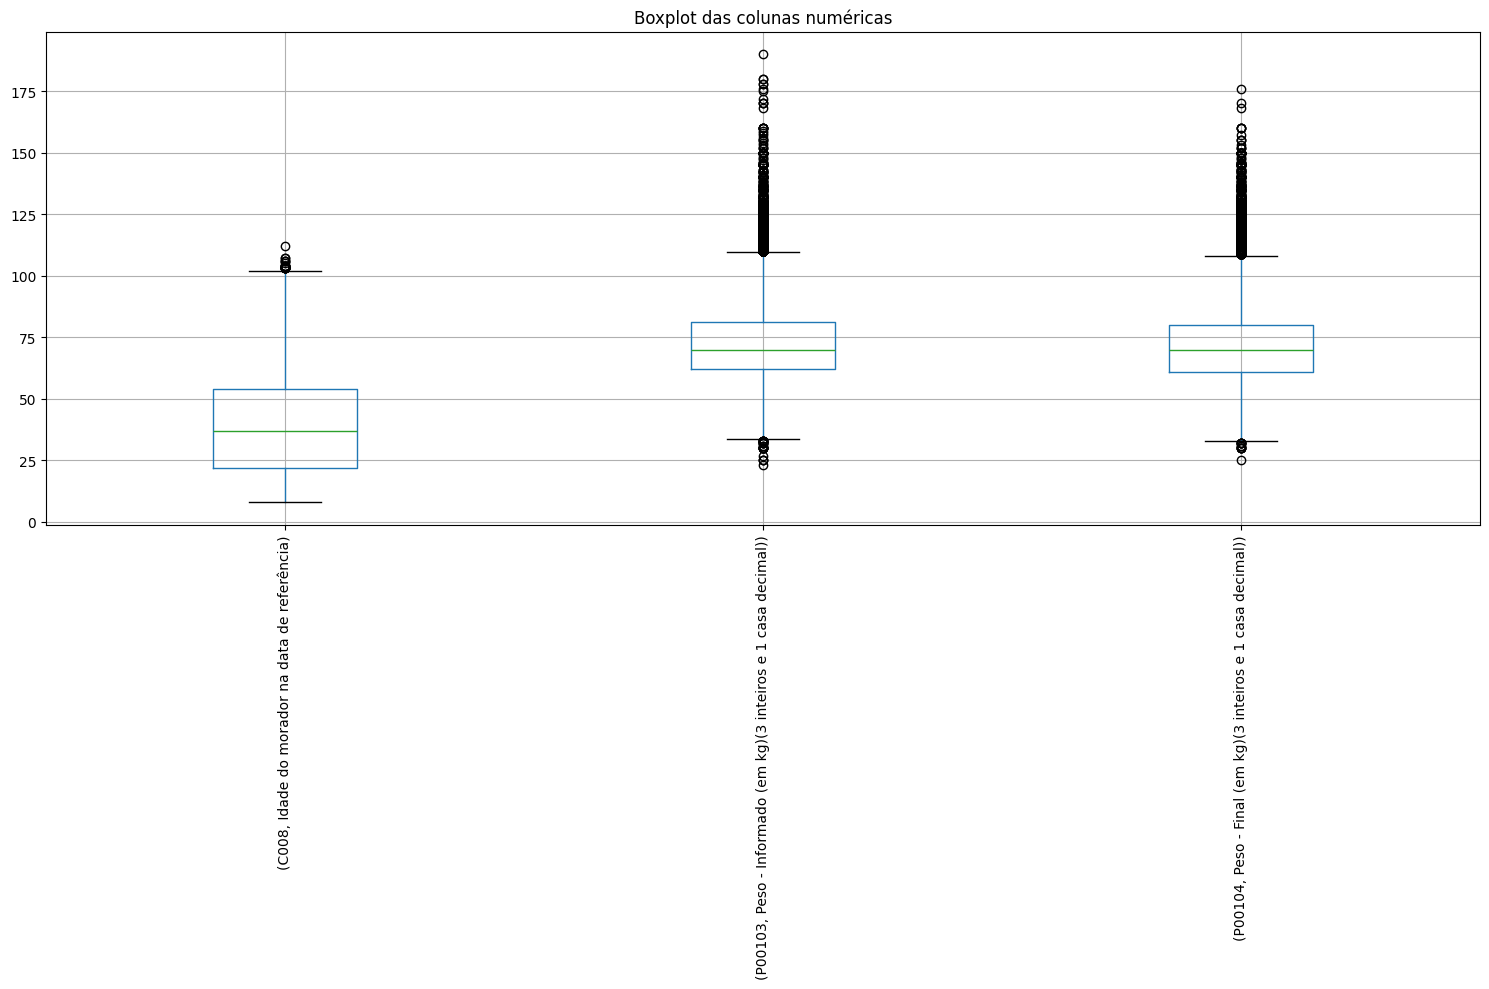

In [219]:
from matplotlib import pyplot as plt

depression_explicit = depression_explicit[depression_explicit[("C008", "Idade do morador na data de referência")] >= 8]

df_numerico = depression_explicit.select_dtypes(include='number')

plt.figure(figsize=(15, 10))
df_numerico.boxplot(rot=90)
plt.title('Boxplot das colunas numéricas')
plt.tight_layout()
plt.show()

Removes outliers from numerical data using the IQR method and updates a related dataset to keep only non-outlier rows. Displays a boxplot of the cleaned data.

Limite Inferior:
C008    Idade do morador na data de referência                  -26.0
P00103  Peso - Informado (em kg)(3 inteiros e 1 casa decimal)    33.5
P00104  Peso - Final (em kg)(3 inteiros e 1 casa decimal)        32.5
dtype: float64

Limite Superior:
C008    Idade do morador na data de referência                   102.0
P00103  Peso - Informado (em kg)(3 inteiros e 1 casa decimal)    109.5
P00104  Peso - Final (em kg)(3 inteiros e 1 casa decimal)        108.5
dtype: float64


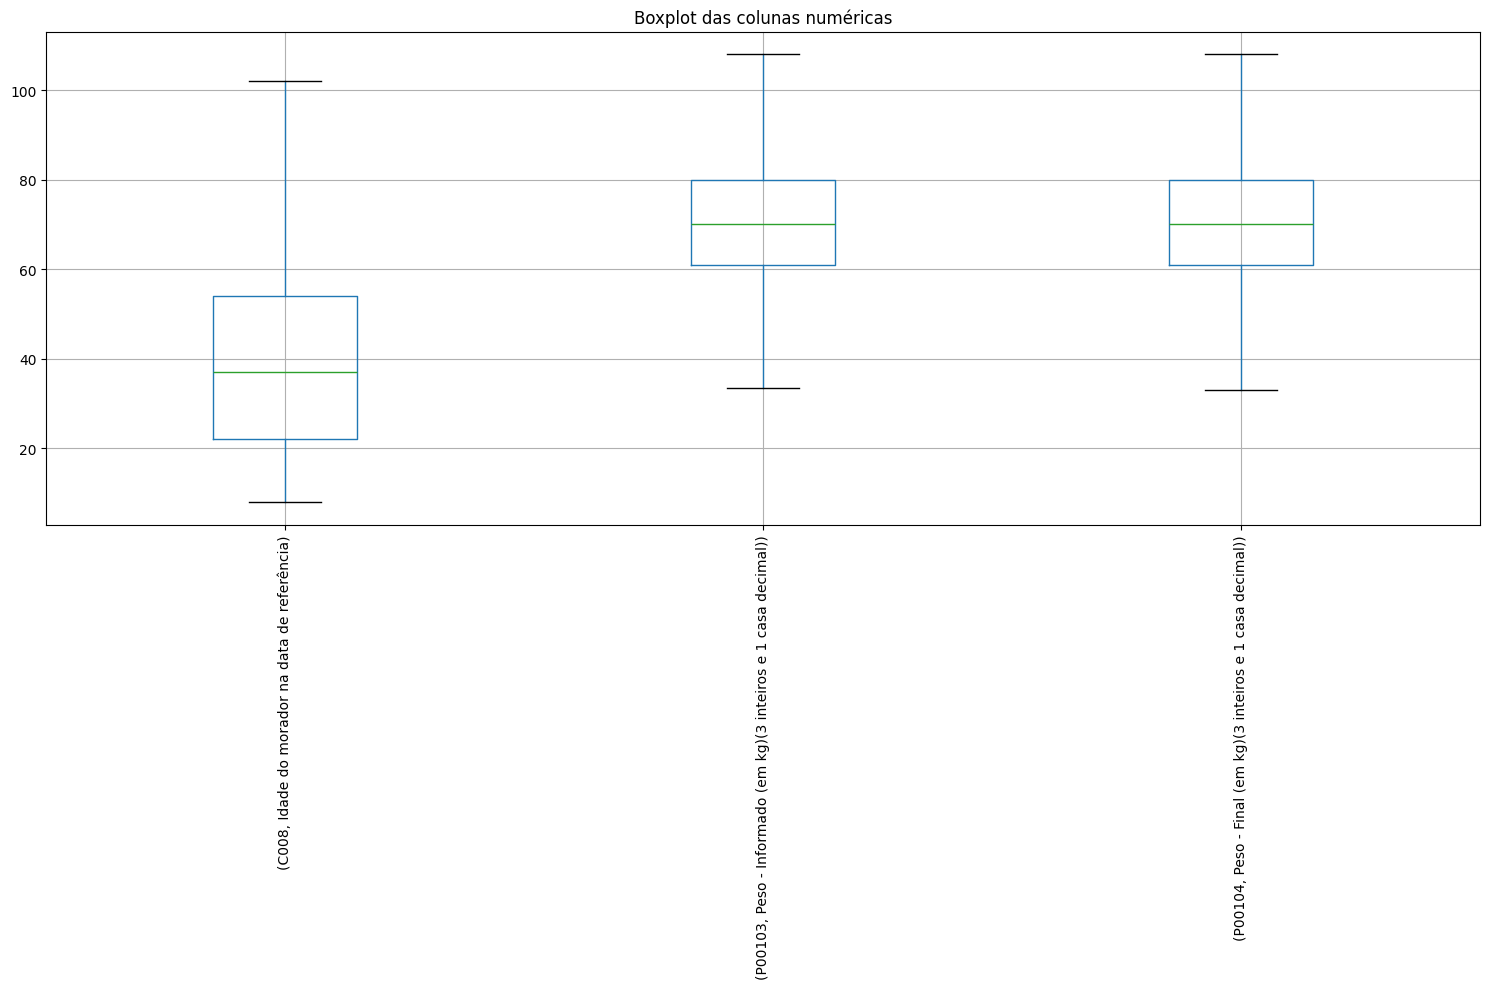

total linhas antes do filtro: 250171
total linhas depois do filtro: 248219


In [220]:
q1 = df_numerico.quantile(0.25)
q3 = df_numerico.quantile(0.75)
# print(q1)
# print(q3)

# Limites
lim_inf = q1 - 1.5 * (q3 - q1)
lim_sup = q3 + 1.5 * (q3 - q1)
print(f"Limite Inferior:\n{lim_inf}")
print()
print(f"Limite Superior:\n{lim_sup}")

# Mantém apenas linhas onde todos os valores estão dentro dos limites
filtro = ~((df_numerico < lim_inf) | (df_numerico > lim_sup)).any(axis=1)
df_sem_outliers = df_numerico[filtro]
plt.figure(figsize=(15, 10))
df_sem_outliers.boxplot(rot=90)
plt.title('Boxplot das colunas numéricas')
plt.tight_layout()
plt.show()

print(f"total linhas antes do filtro: {depression_explicit.shape[0]}")
depression_explicit = depression_explicit.loc[filtro]
print(f"total linhas depois do filtro: {depression_explicit.shape[0]}")

In [221]:
(depression_explicit.isnull().mean() * 100).sort_values()

C006     Sexo                                                                                                                                                                                                              0.000000
C008     Idade do morador na data de referência                                                                                                                                                                            0.000000
I00102   tem algum plano de saúde médico particular, de empresa ou órgão público?                                                                                                                                          0.000000
C009     Cor ou raça                                                                                                                                                                                                       0.009669
C011     Qual é o estado civil de ___?                                                  

Filters out rows with more than 40% missing values to improve data quality for analysis or modeling.

In [222]:
# Definir o limite de porcentagem de valores nulos
limite_percentual = 40  # Por exemplo, 40%

# Calcular a porcentagem de valores nulos por linha
percent_null_por_linha = depression_explicit.isnull().mean(axis=1) * 100

# Excluir as linhas que possuem mais do que 'limite_percentual' de valores nulos
depression_explicit = depression_explicit[percent_null_por_linha <= limite_percentual]

# Exibir o DataFrame após a exclusão
print(f"total linhas depois de remover linhas com menos de 60% preenchido: {depression_explicit.shape[0]}")
print((depression_explicit.isnull().mean() * 100).sort_values())

total linhas depois de remover linhas com menos de 60% preenchido: 62504
C006     Sexo                                                                                                                                                                                                              0.000000
C008     Idade do morador na data de referência                                                                                                                                                                            0.000000
I00102   tem algum plano de saúde médico particular, de empresa ou órgão público?                                                                                                                                          0.000000
C011     Qual é o estado civil de ___?                                                                                                                                                                                     0.000000
M01901   Nos úl

Converting MultiIndex columns to simples column names

In [223]:
# depression_explicit.columns = [col[1] for col in depression_explicit.columns]

In [224]:
depression_explicit.shape

(62504, 55)

 Handles missing values in a mixed-type dataset by encoding categorical variables, replacing -1 with NaN, and imputing missing values using K-Nearest Neighbors based on the mode of nearest neighbors. Categorical values are then optionally decoded back to their original form.

In [ ]:
#### Será preciso reduzir mais a base se for usar KNN para preencher os nulos


# import pandas as pd
# import numpy as np
# from sklearn.impute import KNNImputer

# # Suponha que depression_explicit seja seu DataFrame original
# print(depression_explicit.shape)

# # Codificar variáveis categóricas, se necessário
# df_encoded = depression_explicit.copy()

# # Vamos armazenar as colunas categóricas antes de aplicar o factorize
# categorical_columns = df_encoded.select_dtypes(include=['object']).columns

# # Codificar variáveis categóricas, convertendo para inteiros
# for col in categorical_columns:
#     # Aqui estamos aplicando factorize e pegando apenas os valores codificados
#     df_encoded[col], _ = pd.factorize(df_encoded[col])

# # Agora aplicamos KNN para preencher os valores nulos nas colunas
# knn_imputer = KNNImputer(n_neighbors=5)

# # Imputação KNN, somente nas colunas com valores nulos
# df_encoded_imputed = knn_imputer.fit_transform(df_encoded)

# # Converter o resultado de volta para um DataFrame
# df_encoded_imputed = pd.DataFrame(df_encoded_imputed, columns=df_encoded.columns)

# # Se necessário, reconvertendo de volta as colunas categóricas para seus valores originais
# for col in categorical_columns:
#     _, categories = pd.factorize(depression_explicit[col])
#     df_encoded_imputed[col] = df_encoded_imputed[col].apply(lambda x: categories[int(x)] if pd.notna(x) else np.nan)

# # Mostrar o DataFrame com os valores preenchidos
# print(df_encoded_imputed)


In [226]:
depression_explicit[("NEW001","Possui depressão?")].value_counts()

(NEW001, Possui depressão?)
Não    42972
Sim    19532
Name: count, dtype: int64

## 5 Dropna all NaN
Drop rows where all columns are NaN.

In [228]:
total = depression_explicit.shape[0]
depression_explicit = depression_explicit.dropna(how="all")
loss = (total - depression_explicit.shape[0])/total *  100
print(f"Data removed with all ({depression_explicit.shape[1]} columns) NaN: {loss}%")


Data removed with all (55 columns) NaN: 0.0%


## `TODO`: D`types`
Dtypes are already included at DEPRESSION_DICTIONARY['Dtype'] for each Codigo attribute